# Definitions

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
from scipy.interpolate import interp1d
import numpy as np
import HallTransport
import Analysis
import Hamiltonians
from common import *
from common1 import *

/Users/lehuuthong/miniconda3/envs/kwant-env/lib/python3.10/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [3]:
import os
from dask import delayed, compute
from dask.distributed import Client
from dask import config
config.set(scheduler='threads')
n_workers = os.cpu_count()-2
threads_per_worker = 1
client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker)
print("Number of cores Dask is using:", len(client.ncores()))

np.set_printoptions(precision=8, suppress=True)

Number of cores Dask is using: 8


# E_F to n_e conversion

10 QAH energies closest to 0 at kx=0:
[ 0.00093758 -0.00093758 -0.6601146   0.6601146  -0.84051035  0.84051035
 -1.05586303  1.05586303  1.24476829 -1.24476829]
10 Axion energies closest to 0 at kx=0:
[ 0.6420404  -0.6420404   0.74818913 -0.74818913 -0.91180817  0.91180817
  1.10861909 -1.10861909  1.24274021 -1.24274021]


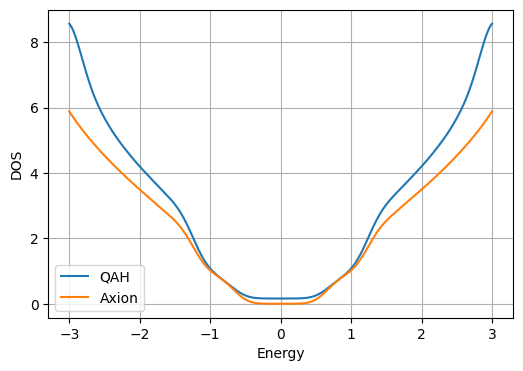

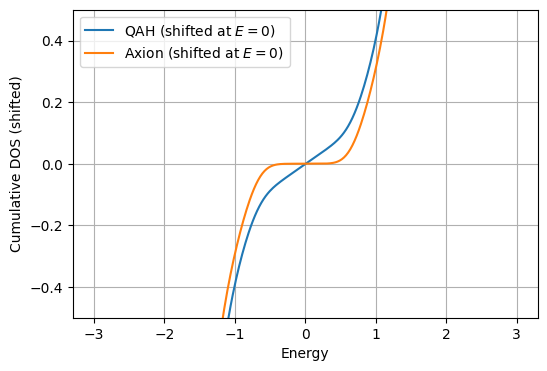

In [4]:
## DOS - E_F mapping
ParaTwoSurface_QAH = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 0.6, 'Mt': 2, 'Mb': 1, 'Es': 0, 'V0': 0}
ParaTwoSurface_Axion = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 0.6, 'Mt': 2, 'Mb': -1, 'Es': 0, 'V0': 0}
Projector_top = np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,0,0],
                        [0,0,0,0]])
Projector_bottom = np.array([[0,0,0,0],
                            [0,0,0,0],
                            [0,0,1,0],
                            [0,0,0,1]])

Hoppings_QAH = TwoSurfaceModel(*ParaTwoSurface_QAH.values())
Hoppings_Axion = TwoSurfaceModel(*ParaTwoSurface_Axion.values())

Ny, Nx, Nz = 20, 1, 1
onsite = Projector_top
tx= ty= tz = np.zeros_like(onsite)
Projector_TopSlab = create_hamiltonian_cube(onsite, tx, ty, tz, Nx, Ny, Nz).toarray()

onsite = Projector_bottom
tx= ty= tz = np.zeros_like(onsite)
Projector_BottomSlab = create_hamiltonian_cube(onsite, tx, ty, tz, Nx, Ny, Nz).toarray()

norb = Hoppings_QAH[0].shape[0]
Nvec = Ny * Nx * Nz * norb
Nbands = Nvec
Nk = 401
kxlist = np.linspace(-np.pi, np.pi, Nk)
def BandData(kxlist, Hoppings, Projector_TopSlab, Nbands, Ny, Nz):
    Elist = np.zeros((len(kxlist), Nbands))
    StateList = np.zeros((len(kxlist), Nbands, Nvec), dtype=complex)
    for i, kx in enumerate(kxlist):
        Elist[i], StateList[i] = Bandstructure_kx(kx, Ny, Nz, Hoppings, None, None, Magnetization=False)
    
    top_weights = np.zeros((Nk, Nbands))
    for ib in range(Nbands):
        for ik in range(Nk):
            psi = StateList[ik, ib]/np.linalg.norm(StateList[ik, ib])  # Normalize the state
            # <psi|P|psi>
            top_weights[ik, ib] = np.real(np.dot(psi.conj(), Projector_TopSlab @ psi))
    top_weights
    return Elist, top_weights, StateList
Elist_QAH, top_weights_QAH, StateList_QAH = BandData(kxlist, Hoppings_QAH, Projector_TopSlab, Nbands, Ny, Nz)
Elist_Axion, top_weights_Axion, StateList_Axion = BandData(kxlist, Hoppings_Axion, Projector_TopSlab, Nbands, Ny, Nz)
# Find the index in kxlist closest to kx=0
kx_zero_idx = np.abs(kxlist - 0).argmin()

# Get the energy values at kx=0 for both Axion and QAH bands
energies_QAH_at_kx0 = Elist_QAH[kx_zero_idx]
energies_Axion_at_kx0 = Elist_Axion[kx_zero_idx]

# Find the indices of the 10 energies closest to 0 for each
closest_QAH_indices = np.argsort(np.abs(energies_QAH_at_kx0))[:10]
closest_Axion_indices = np.argsort(np.abs(energies_Axion_at_kx0))[:10]

print("10 QAH energies closest to 0 at kx=0:")
print(energies_QAH_at_kx0[closest_QAH_indices])

print("10 Axion energies closest to 0 at kx=0:")
print(energies_Axion_at_kx0[closest_Axion_indices])
def calculate_dos(Elist, energy_grid, broadening=0.15):
    """
    Calculate the density of states (DOS) using Gaussian broadening.

    Parameters:
    Elist : ndarray
        Shape (Nk, Nbands), eigenvalues at each k-point.
    energy_grid : ndarray
        1D array of energies at which to evaluate the DOS.
    broadening : float
        Standard deviation of the Gaussian broadening.

    Returns:
    dos : ndarray
        DOS evaluated at each point in energy_grid.
    """
    Nk, Nbands = Elist.shape
    dos = np.zeros_like(energy_grid)
    for ik in range(Nk):
        for ib in range(Nbands):
            dos += np.exp(-((energy_grid - Elist[ik, ib])**2) / (2 * broadening**2))
    dos /= (np.sqrt(2 * np.pi) * broadening * Nk)
    return dos

# Example usage:
mu=3.
energy_grid = np.linspace(-mu, mu, 400)
dos_QAH = calculate_dos(Elist_QAH, energy_grid)
dos_Axion = calculate_dos(Elist_Axion, energy_grid)

plt.figure(figsize=(6,4))
plt.plot(energy_grid, dos_QAH, label='QAH')
plt.plot(energy_grid, dos_Axion, label='Axion')
plt.xlabel('Energy')
plt.ylabel('DOS')
plt.legend()
plt.grid(True)
plt.show()
# Find the index in energy_grid closest to E=0
zero_idx = np.abs(energy_grid - 0).argmin()

# Calculate cumulative sum for both DOS arrays
cumsum_dos_QAH = np.cumsum(dos_QAH) * (energy_grid[1] - energy_grid[0])
cumsum_dos_Axion = np.cumsum(dos_Axion) * (energy_grid[1] - energy_grid[0])

# Subtract the value at E=0
carrier_density_QAH = cumsum_dos_QAH - cumsum_dos_QAH[zero_idx]
carrier_density_Axion = cumsum_dos_Axion - cumsum_dos_Axion[zero_idx]

plt.figure(figsize=(6,4))
plt.plot(energy_grid, carrier_density_QAH, label='QAH (shifted at $E=0$)')
plt.plot(energy_grid, carrier_density_Axion, label='Axion (shifted at $E=0$)')
plt.xlabel('Energy')
plt.ylabel('Cumulative DOS (shifted)')
plt.legend()
plt.grid(True)
plt.ylim(-0.5, 0.5)  # Adjust y-limits for better visibility
plt.show()
# Save energy_grid, dos_QAH, dos_Axion as columns in a text file with a title line
with open("Data/EF_DOS_conversion.txt", "w") as f:
    np.savetxt(f, np.column_stack([energy_grid, carrier_density_QAH, carrier_density_Axion]), header="Elist Carrier_QAH Carrier_Axion", comments='#')

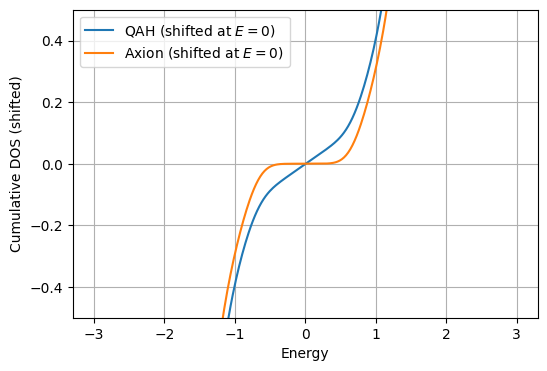

In [5]:
# Import arrays from EF_DOS_conversion.txt
data = np.loadtxt("Data/EF_DOS_conversion.txt", comments="#")
Elist1 = data[:, 0]
Carrier_QAH = data[:, 1]
Carrier_Axion = data[:, 2]
plt.figure(figsize=(6,4))
plt.plot(Elist1, Carrier_QAH, label='QAH (shifted at $E=0$)')
plt.plot(Elist1, Carrier_Axion, label='Axion (shifted at $E=0$)')
plt.xlabel('Energy')
plt.ylabel('Cumulative DOS (shifted)')
plt.legend()
plt.grid(True)
plt.ylim(-0.5, 0.5)  # Adjust y-limits for better visibility
plt.show()


# Plotting functions

In [6]:
def PlotHallConductance(Elist, Hall_resistance, ax=None, gapindex = None, xmax=None, legend=True, xlabel=r'$E_F$', ylabel=None, hide_x = False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,2.5))
    else:
        fig = ax.figure
    linestyles = ['-', '-', '-', '-']
    markers = ['o', 'o', 'o', 'o']
    colors = ['tab:blue', 'r', 'r', 'r']
    linewidths = [0, 0, 0, 1]
    markersizes = [2, 2, 0, 0]
    zorders = [1,2,2,1]
    labels = [r'$R^{\omega}_{xx}$', r'$R^{\omega}_{yx}$']
    for key in ['R54', 'R24']:
        value = Hall_resistance[key]
        if gapindex is None:
            ax.plot(Elist, value, 
                    label=labels.pop(0),
                    linestyle=linestyles.pop(0),
                    marker = markers.pop(0),
                    color = colors.pop(0),
                    markersize=markersizes.pop(0),
                    linewidth=linewidths.pop(0),
                    zorder=zorders.pop(0)) 
        else:
            lines = ax.plot(Elist[:gapindex+1], value[:gapindex+1],
                        Elist[gapindex+1:], value[gapindex+1:],
                        label=labels.pop(0),
                        linestyle=linestyles.pop(0),
                        marker = markers.pop(0),
                        color = colors.pop(0),
                        markersize=markersizes.pop(0),
                        linewidth=linewidths.pop(0),
                        zorder=zorders.pop(0)) 
            ax.axvspan(Elist[gapindex], Elist[gapindex+1], color='lightgray', alpha=0.5, label=None)
            lines[1].set_label(None)
            
    ax.grid(True, linestyle=':', linewidth=1., zorder=-1)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='both', labelsize=12, direction='in')
    # ax.set_ylabel('Resistance')
    if legend: 
        ax.legend(loc='upper right', fontsize=15, frameon=True,
                borderpad=0.2, 
                handlelength=0.5, handletextpad=0.0, 
                bbox_to_anchor=(1., 1.))
    if xmax is not None:
        ax.set_xlim(-xmax, xmax)
    if hide_x:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    return fig, ax

In [7]:
def PlotHallConductance_2nd_v1(Elist, Hall_conductance_2nd, ax = None, gapindex = None, downsample=1, 
                                    ylabel=None, xlabel=None, legend=False, xmax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 2))
    else:
        fig = ax.figure
    linestyles = ['-', '--', '-', '-']
    markers = ['o', 'o', 'o', 'o']
    colors = ['tab:blue', 'red', 'b', 'y']
    linewidths = [1.5, 1.5, 0, 0]
    markersizes = [0, 0, 0, 0]
    labels = ['$V^{2\omega}_{xx,R}$', '$V^{2\omega}_{yx,D}$', 'Hall R15', 'Hall R24'] # The order defined in the dict of Hall_conductance_2nd
    for key, value in Hall_conductance_2nd.items():
        if key=='R54' or key=='R24':
            if gapindex is None:
                ax.plot(Elist[::downsample], value[::downsample], 
                        label=labels.pop(0),
                        linestyle=linestyles.pop(0),
                        marker = markers.pop(0),
                        color = colors.pop(0),
                        markersize=markersizes.pop(0),
                        linewidth=linewidths.pop(0)) 

            else:
                lines = ax.plot(Elist[:gapindex+1:downsample], value[:gapindex+1:downsample],
                            Elist[gapindex+1::downsample], value[gapindex+1::downsample],
                            label=labels.pop(0),
                            linestyle=linestyles.pop(0),
                            marker = markers.pop(0),
                            color = colors.pop(0),
                            markersize=markersizes.pop(0),
                            linewidth=linewidths.pop(0)) 
                lines[1].set_label(None)
                ax.axvspan(Elist[gapindex], Elist[gapindex+1], color='lightblue', alpha=0.5, label=None)

    ymax1 = np.max(np.abs(Hall_conductance_2nd['R54']))
    ymax2 = np.max(np.abs(Hall_conductance_2nd['R24']))
    ymax = max(ymax1, ymax2)
    ax.set_ylim(-1.2*ymax, 1.2* ymax)
    if xmax is not None:
        ax.set_xlim(-xmax, xmax)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle=':', linewidth=1.)
    if legend: 
        ax.legend(loc='upper right', fontsize=15, frameon=True,
                borderpad=0.2, 
                handlelength=1, handletextpad=0.0, 
                bbox_to_anchor=(1., 1.))
    ax.tick_params(axis='both', labelsize=11)
    # ax.set_xlabel(xlabel, fontsize=14)
    return fig, ax

In [8]:
def PlotHallConductance_2nd_v1_1(Elist, Hall_conductance_2nd, ax = None, gapindex = None, downsample=1, 
                                    ylabel=None, xlabel=None, legend=False, xmax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 2))
    else:
        fig = ax.figure
    linestyles = ['-', '-', '-', '-']
    markers = ['o', 'o', 'o', 'o']
    colors = ['tab:blue', 'red', 'b', 'y']
    linewidths = [1.5, 1.5, 0, 0]
    markersizes = [0, 0, 0, 0]
    labels = ['$V^{2\omega}_{xx,R}$', '$V^{2\omega}_{yx,U}$', 'Hall R15', 'Hall R24']
    for key, value in Hall_conductance_2nd.items():
        if key=='R54' or key=='R15':
            if key=='R24' or key=='R15': factor=-1
            else: factor=1
            if gapindex is None:
                ax.plot(Elist[::downsample], factor*np.array(value[::downsample]), 
                        label=labels.pop(0),
                        linestyle=linestyles.pop(0),
                        marker = markers.pop(0),
                        color = colors.pop(0),
                        markersize=markersizes.pop(0),
                        linewidth=linewidths.pop(0)) 

            else:
                lines = ax.plot(Elist[:gapindex+1:downsample], factor*np.array(value[:gapindex+1:downsample]),
                            Elist[gapindex+1::downsample], value[gapindex+1::downsample],
                            label=labels.pop(0),
                            linestyle=linestyles.pop(0),
                            marker = markers.pop(0),
                            color = colors.pop(0),
                            markersize=markersizes.pop(0),
                            linewidth=linewidths.pop(0)) 
                lines[1].set_label(None)
                ax.axvspan(Elist[gapindex], Elist[gapindex+1], color='lightblue', alpha=0.5, label=None)

    ymax1 = np.max(np.abs(Hall_conductance_2nd['R54']))
    ymax2 = np.max(np.abs(Hall_conductance_2nd['R15']))
    ymax = max(ymax1, ymax2)
    ax.set_ylim(-1.2*ymax, 1.2* ymax)
    if xmax is not None:
        ax.set_xlim(-xmax, xmax)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle=':', linewidth=1.)
    if legend: 
        ax.legend(loc='upper right', fontsize=15, frameon=True,
                borderpad=0.2, 
                handlelength=0.5, handletextpad=0.0, 
                bbox_to_anchor=(1., 1.))
    ax.tick_params(axis='both', labelsize=11)
    # ax.set_xlabel(xlabel, fontsize=14)
    return fig, ax

In [9]:
def PlotHallConductance_2nd_v2(Elist, Hall_resistance_2nd, ax=None, gapindex = None, \
                               Keys=['R12', 'R54'], Labels=[r'$R^{2\omega}_{xx,L}$', r'$R^{2\omega}_{xx,R}$'], Colors = ['tab:blue','tab:blue'], \
                               xmax=None, legend=True, xlabel=r'$E_F$', ylabel=None, hide_x = False):
    if ax is None: 
        fig, ax = plt.subplots(figsize=(3, 2.5))
    else:
        fig = ax.figure
    linestyles = [':', '-', '-', '-']
    markers = ['o', 'o', 'o', 'o']
    colors = Colors.copy()
    linewidths = [2, 2, 0, 1]
    markersizes = [0, 0, 3, 0]
    zorders = [1,1,2,1]
    labels = Labels.copy()
    for key in Keys:
        if key=='R24' or key=='R15': factor=-1
        else: factor=1
        value= factor*np.array(Hall_resistance_2nd[key])
        if gapindex is None:
            ax.plot(Elist, value, 
                    label=labels.pop(0),
                    linestyle=linestyles.pop(0),
                    marker = markers.pop(0),
                    color = colors.pop(0),
                    markersize=markersizes.pop(0),
                    linewidth=linewidths.pop(0),
                    zorder=zorders.pop(0)) 
        else:
            lines = ax.plot(Elist[:gapindex+1], value[:gapindex+1],
                        Elist[gapindex+1:], value[gapindex+1:],
                        label=labels.pop(0),
                        linestyle=linestyles.pop(0),
                        marker = markers.pop(0),
                        color = colors.pop(0),
                        markersize=markersizes.pop(0),
                        linewidth=linewidths.pop(0),
                        zorder=zorders.pop(0))
            ax.axvspan(Elist[gapindex], Elist[gapindex+1], color='lightgray', alpha=0.5, label=None, zorder=0)
            lines[1].set_label(None)
    ax.grid(True, linestyle=':', linewidth=1., zorder=-1)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='both', labelsize=12,direction='in')
    # ax.set_ylabel('Resistance')
    if legend: 
        ax.legend(loc='upper right', fontsize=15, frameon=True,
                borderpad=0.2, 
                handlelength=0.5, handletextpad=0.0, 
                bbox_to_anchor=(1., 1.))
    if xmax is not None:
        ax.set_xlim(-xmax, xmax)
    if hide_x:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    return fig, ax

In [10]:
def PlotHallConductance_2nd_abseparation(Elist, Hall_resistance_2nd, Hall_resistance_a_2nd, Hall_resistance_b_2nd, ax=None, gapindex = None,\
                                         xmax=None, legend=True, xlabel=r'$E_F$', ylabel=None, hide_x = False):
    if ax is None: 
        fig, ax = plt.subplots(figsize=(3, 2.5))
    else:
        fig = ax.figure
    linestyles = ['-', '-', '-', '-']
    markers = ['o', 'o', 'o', 'o']
    colors = ['tab:blue', 'gold', 'darkorange', 'r']
    linewidths = [2, 1.5, 1.5, 1]
    markersizes = [0, 0, 0, 0]
    zorders = [3,2,2,1]
    labels = [r'$R^{2\omega}_{xx,R}$', r'$R^{2\omega, (a)}_{xx,R}$', r'$R^{2\omega, (b)}_{xx,R}$']
    for Resistance in [Hall_resistance_2nd, Hall_resistance_a_2nd, Hall_resistance_b_2nd]:
        value = Resistance['R54']
        if gapindex is None:
            ax.plot(Elist, value, 
                    label=labels.pop(0),
                    linestyle=linestyles.pop(0),
                    marker = markers.pop(0),
                    color = colors.pop(0),
                    markersize=markersizes.pop(0),
                    linewidth=linewidths.pop(0),
                    zorder=zorders.pop(0),
                    path_effects=[pe.withStroke(linewidth=1, foreground="white")]) 
        else:
            lines = ax.plot(Elist[:gapindex+1], value[:gapindex+1],
                        Elist[gapindex+1:], value[gapindex+1:],
                        label=labels.pop(0),
                        linestyle=linestyles.pop(0),
                        marker = markers.pop(0),
                        color = colors.pop(0),
                        markersize=markersizes.pop(0),
                        linewidth=linewidths.pop(0),
                        zorder=zorders.pop(0),
                        path_effects=[pe.withStroke(linewidth=1, foreground="white")]) 
            lines[1].set_label(None)
            ax.axvspan(Elist[gapindex], Elist[gapindex+1], color='lightgray', alpha=0.5, label=None, zorder=0)
    ax.grid(True, linestyle=':', linewidth=1., zorder=-1)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='both', labelsize=12, direction='in')
    # ax.set_ylabel('Resistance')
    if legend: 
        # ax.legend(loc='upper right', fontsize=14, frameon=True)
        ax.legend(loc='upper right', fontsize=15, frameon=True,
                borderpad=0.2, 
                handlelength=0.5, handletextpad=0.0, 
                bbox_to_anchor=(1.05, 1.1))
        # add_colored_text_legend(ax, labels[0:-1], colors[0:3], 
        #                       loc='upper right', fontsize=14)
    if xmax is not None:
        ax.set_xlim(-xmax, xmax)
    if hide_x:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    return fig, ax

# Generate Data

Creating the system


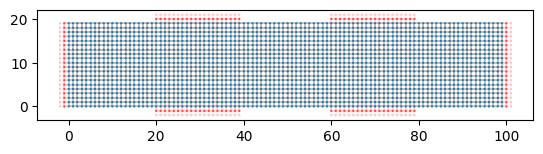

Bandgap = 0.0019
Calculating second order resistance as a function of Fermi energy
Saved to: Data/Data_QAH_1.pkl


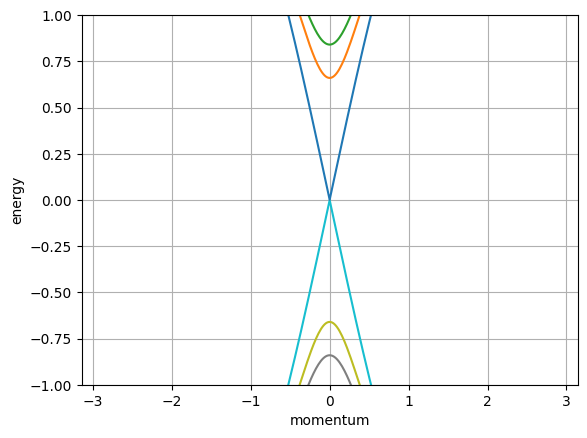

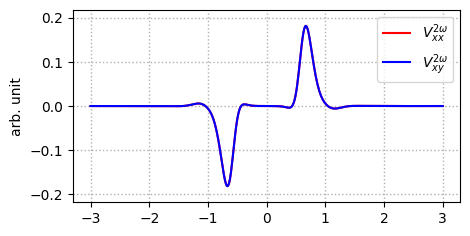

In [7]:
para_QAH = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': 1.2, 'Mb': 0.6, 'Es': 0, 'V0': 0}
M_min = para_QAH['g']*min(abs(para_QAH['Mt']),abs(para_QAH['Mb']))
mu = 3
shift = 0
W = 20
L = 100
lead_pos = [[0, W], [1*L//5-shift, 2*L//5-shift], [3*L//5, 4*L//5], [0, W], [3*L//5, 4*L//5], [1*L//5-shift, 2*L//5-shift]]
Hamiltonian = Analysis.SystemCreator(para_QAH, Hamiltonians.Two_surface_model , (W, L), lead_pos=lead_pos)
Elist = np.linspace(-mu, mu,400)
HallData_2nd = Analysis.Analysis_2nd(Hamiltonian, Elist, dE_derivative = 1e-6, dE_avg = 0.15, plotting=False, ab_separation=True)
HallData_2nd_saved = save_and_reload(HallData_2nd, filename="Data/Data_QAH_1.pkl")
fig, ax = HallTransport.HallResistanceData_2nd.PlotHallConductance_2nd_v1(HallData_2nd_saved.Elist, HallData_2nd_saved.Hall_resistance_2nd_avg, downsample=1)

Creating the system


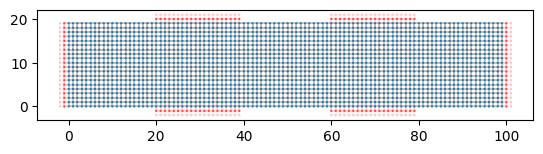

Bandgap = 0.0019
Calculating second order resistance as a function of Fermi energy
Saved to: Data/Data_QAH_2.pkl


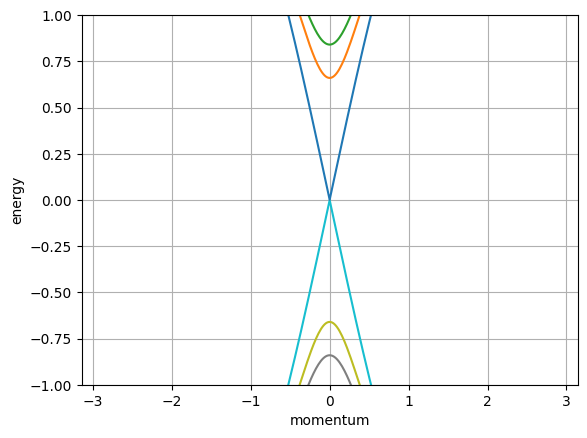

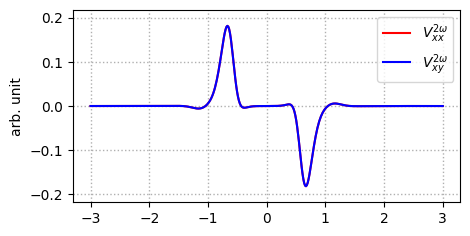

In [21]:
para_QAH = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': -1.2, 'Mb': -0.6, 'Es': 0, 'V0': 0}
M_min = para_QAH['g']*min(abs(para_QAH['Mt']),abs(para_QAH['Mb']))
mu = 3
shift = 0
W = 20
L = 100
lead_pos = [[0, W], [1*L//5-shift, 2*L//5-shift], [3*L//5, 4*L//5], [0, W], [3*L//5, 4*L//5], [1*L//5-shift, 2*L//5-shift]]
Hamiltonian = Analysis.SystemCreator(para_QAH, Hamiltonians.Two_surface_model , (W, L), lead_pos=lead_pos)
Elist = np.linspace(-mu, mu,400)
HallData_2nd = Analysis.Analysis_2nd(Hamiltonian, Elist, dE_derivative = 1e-6, dE_avg = 0.15, plotting=False, ab_separation=True)
HallData_2nd_saved = save_and_reload(HallData_2nd, filename="Data/Data_QAH_2.pkl")
fig, ax = HallTransport.HallResistanceData_2nd.PlotHallConductance_2nd_v1(HallData_2nd_saved.Elist, HallData_2nd_saved.Hall_resistance_2nd_avg, downsample=1)

Creating the system


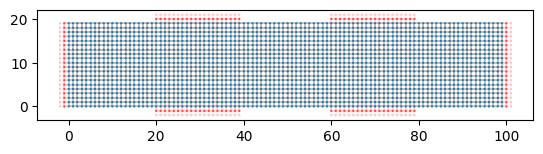

Bandgap = 1.2841
Calculating first order resistance as a function of Fermi energy
-0.6482412060301508
0.6482412060301508
Calculating first order resistance as a function of Fermi energy
-0.6431907009796457
0.6431907009796457
Calculating second order resistance as a function of Fermi energy
Saved to: Data/Data_Axion_1.pkl


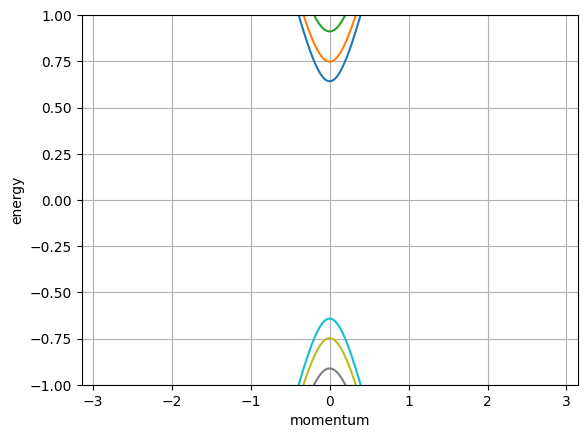

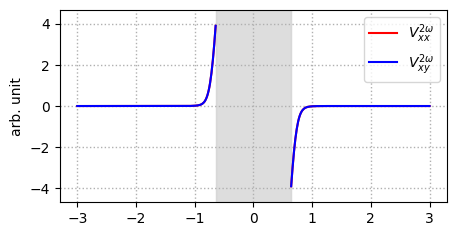

In [22]:
para_Axion = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': 1.2, 'Mb': -0.6, 'Es': 0, 'V0': 0}
mu = 3
shift = 0
W = 20 #Ly
L = 100 #Lx
lead_pos = [[0, W], [1*L//5-shift, 2*L//5-shift], [3*L//5, 4*L//5], [0, W], [3*L//5, 4*L//5], [1*L//5-shift, 2*L//5-shift]]
Hamiltonian = Analysis.SystemCreator(para_Axion, Hamiltonians.Two_surface_model , (W, L), lead_pos=lead_pos)

Elist = np.linspace(-mu, mu , 200)
HallData_1st = Analysis.Analysis_1st(Hamiltonian, Elist, dE_avg = 0.1, det_threshold=1e-6, plotting=False)
E1 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex]
E2 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex+1]
print(E1)
print(E2)

# # Increase precision
separation_points = [E1-0.1, E1+0.1, E2-0.1, E2+0.1]
npoints = np.array([100,1,100]) # avoid the gap
Elist = create_Elist(separation_points, npoints)
HallData_1st = Analysis.Analysis_1st(Hamiltonian, Elist, dE_avg = 0.1, det_threshold=1e-6, plotting=False)
E1 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex]
E2 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex+1]
print(E1)
print(E2)
NN=400//2
separation_points = [-mu, E1, E2, mu]
npoints = np.array([NN,1,NN]) # avoid the gap
gapindex = NN-1
Elist = create_Elist(separation_points, npoints)      

HallData_2nd = Analysis.Analysis_2nd(Hamiltonian, Elist, dE_derivative = 1e-6, dE_avg = 0.15,gapindex=gapindex, plotting=False, ab_separation=True)
HallData_2nd_saved = save_and_reload(HallData_2nd, filename="Data/Data_Axion_1.pkl")
fig, ax = HallTransport.HallResistanceData_2nd.PlotHallConductance_2nd_v1(HallData_2nd_saved.Elist, HallData_2nd_saved.Hall_resistance_2nd_avg, gapindex = HallData_2nd_saved.gapindex, downsample=1)

Creating the system


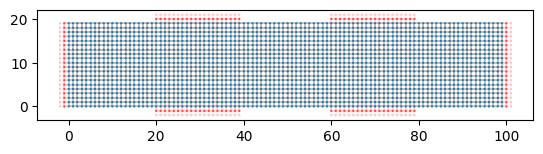

Bandgap = 1.2841
Calculating first order resistance as a function of Fermi energy
-0.6482412060301508
0.6482412060301508
Calculating first order resistance as a function of Fermi energy
-0.6431907009796457
0.6431907009796457
Calculating second order resistance as a function of Fermi energy
Saved to: Data/Data_Axion_2.pkl


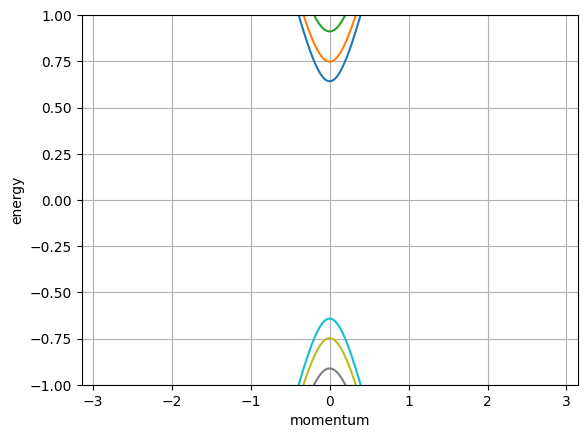

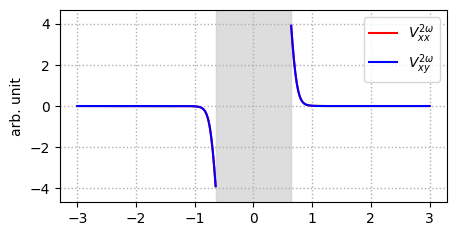

In [23]:
para_Axion = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': -1.2, 'Mb': 0.6, 'Es': 0, 'V0': 0}
mu = 3
shift = 0
W = 20 #Ly
L = 100 #Lx
lead_pos = [[0, W], [1*L//5-shift, 2*L//5-shift], [3*L//5, 4*L//5], [0, W], [3*L//5, 4*L//5], [1*L//5-shift, 2*L//5-shift]]
Hamiltonian = Analysis.SystemCreator(para_Axion, Hamiltonians.Two_surface_model , (W, L), lead_pos=lead_pos)

Elist = np.linspace(-mu, mu , 200)
HallData_1st = Analysis.Analysis_1st(Hamiltonian, Elist, dE_avg = 0.1, det_threshold=1e-6, plotting=False)
E1 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex]
E2 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex+1]
print(E1)
print(E2)

# # Increase precision
separation_points = [E1-0.1, E1+0.1, E2-0.1, E2+0.1]
npoints = np.array([100,1,100]) # avoid the gap
Elist = create_Elist(separation_points, npoints)
HallData_1st = Analysis.Analysis_1st(Hamiltonian, Elist, dE_avg = 0.1, det_threshold=1e-6, plotting=False)
E1 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex]
E2 = HallData_1st.Elist_nonsingular[HallData_1st.gapindex+1]
print(E1)
print(E2)
NN=400//2
separation_points = [-mu, E1, E2, mu]
npoints = np.array([NN,1,NN]) # avoid the gap
gapindex = NN-1
Elist = create_Elist(separation_points, npoints)      

HallData_2nd = Analysis.Analysis_2nd(Hamiltonian, Elist, dE_derivative = 1e-6, dE_avg = 0.15,gapindex=gapindex, plotting=False, ab_separation=True)
HallData_2nd_saved = save_and_reload(HallData_2nd, filename="Data/Data_Axion_2.pkl")
fig, ax = HallTransport.HallResistanceData_2nd.PlotHallConductance_2nd_v1(HallData_2nd_saved.Elist, HallData_2nd_saved.Hall_resistance_2nd_avg, gapindex = HallData_2nd_saved.gapindex, downsample=1)

Creating the system


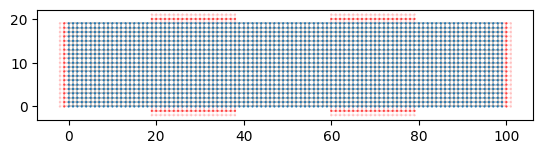

Bandgap = 0.0227
Calculating first order resistance as a function of Fermi energy
Calculating second order resistance as a function of Fermi energy
Saved to: Data/Data_QAH_Assymetric.pkl


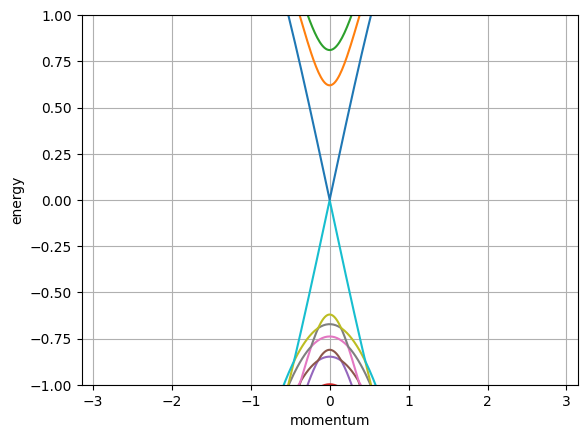

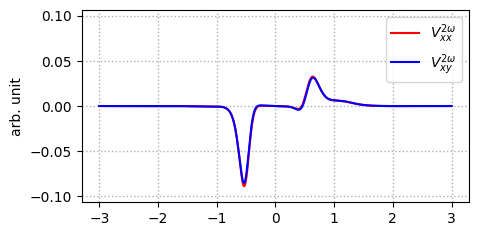

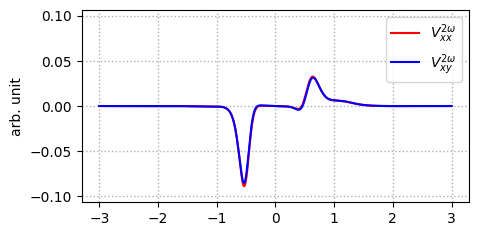

In [27]:
para_QAH_Assymetric = {'vf':2, 'm0': 0.2, 'B': -1, 'g': 0.6, 'Mt': 2, 'Mb': 1, 'Es': 0., 'V0': 0, 'Eb': -0.65, 'B1': -1}
Elist = np.linspace(-3, 3, 800)

shift = 1
W = 20
L = 100
lead_pos = [[0, W], [1*L//5-shift, 2*L//5-shift], [3*L//5, 4*L//5], [0, W], [3*L//5, 4*L//5], [1*L//5-shift, 2*L//5-shift]]
Hamiltonian = Analysis.SystemCreator(para_QAH_Assymetric, Hamiltonians.Two_surface_and_bulk , (W, L), lead_pos=lead_pos)

HallData_1st = Analysis.Analysis_1st(Hamiltonian, Elist, dE_avg = 0.15, plotting=False)
HallData_2nd = Analysis.Analysis_2nd(Hamiltonian, HallData_1st.Elist_nonsingular, dE_derivative = 1e-6, dE_avg = 0.15, plotting=False)
fig, ax = HallTransport.HallResistanceData_2nd.PlotHallConductance_2nd_v1(HallData_2nd.Elist, HallData_2nd.Hall_resistance_2nd_avg, downsample=1)
HallData_2nd_saved = save_and_reload(HallData_2nd, filename="Data/Data_QAH_Assymetric.pkl")
fig, ax = HallTransport.HallResistanceData_2nd.PlotHallConductance_2nd_v1(HallData_2nd_saved.Elist, HallData_2nd_saved.Hall_resistance_2nd_avg, downsample=1)

# Generate Plots

## Fig4, ExtendedFig8, and FigS9

In [11]:
DataList = []
filenames = ["Data/Data_QAH_2.pkl",
             "Data/Data_Axion_2.pkl",
             "Data/Data_Axion_1.pkl",
             "Data/Data_QAH_1.pkl"]
for filename in filenames:
    HallData_2nd = load_object_state_v2(HallTransport.HallResistanceData_2nd, filename)
    DataList.append(HallData_2nd)

/var/folders/7x/4gmvgg4n2x1916n66jhwbf4w0000gn/T/ipykernel_17819/3315445109.py:111: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



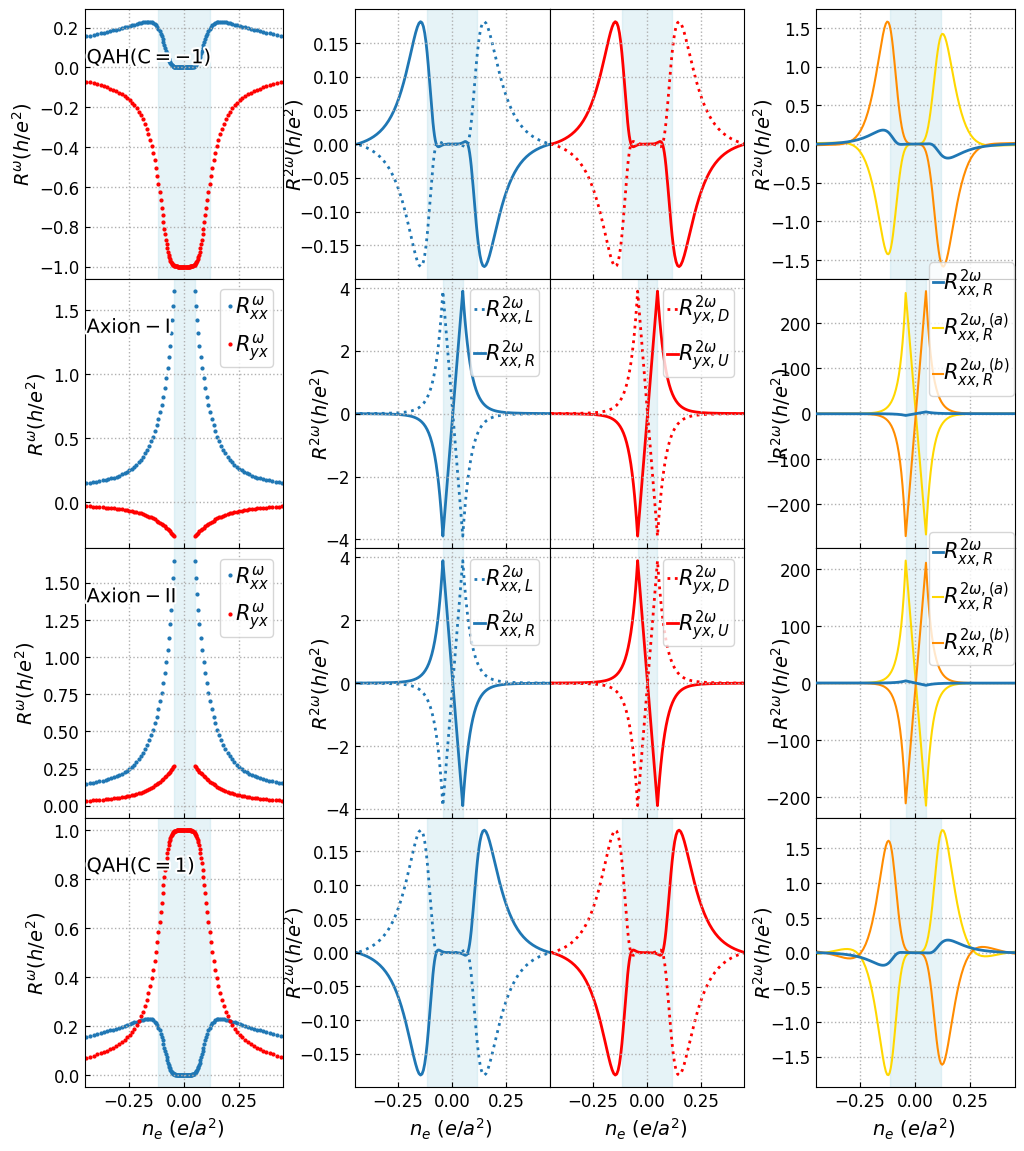

In [30]:
fig = plt.figure(figsize=(12, 14))
# Create outer grid
gs_outer = gridspec.GridSpec(4, 4, wspace=0.4, hspace=0., width_ratios=[1.25,1,1,1.25])
xmax = 0.45
##################################################################################################
# First row
HallData_2nd = DataList[0]
gapindex1 = np.abs(HallData_2nd.Elist+0.6).argmin()
gapindex2 = np.abs(HallData_2nd.Elist-0.6).argmin()
HallData_2nd.gapindex = None
ax = fig.add_subplot(gs_outer[0,0])
PlotHallConductance(Carrier_QAH, HallData_2nd.Hall_resistance_avg, ax, HallData_2nd.gapindex, xmax=xmax, hide_x=True, legend=False)
ax.text(0.01, 0.8, r"$\mathrm{QAH (C=-1)}$", transform=ax.transAxes, ha='left', fontsize=14, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel(r'$R^\omega (h/e^2)$', fontsize=14)
ax.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
gs_inner_top = gridspec.GridSpecFromSubplotSpec(1, 2, gs_outer[0, 1:3], wspace=0.0)
ax1 = fig.add_subplot(gs_inner_top[0, 0])
ax2 = fig.add_subplot(gs_inner_top[0, 1], sharey=ax1)
PlotHallConductance_2nd_v2(Carrier_QAH, HallData_2nd.Hall_resistance_2nd_avg, ax1, HallData_2nd.gapindex, xmax=xmax, hide_x=True, legend=False)
ax1.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-5)
ax1.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
PlotHallConductance_2nd_v2(Carrier_QAH, HallData_2nd.Hall_resistance_2nd_avg, ax2, HallData_2nd.gapindex, xmax=xmax,\
                           Keys=['R24', 'R15'], Labels=[r"${R}^{2\omega}_{yx,D}$", r'$R^{2\omega}_{yx,U}$'], Colors=['r', 'r'], legend=False, xlabel=r"$n_e\ (e/a^2)$ ")
ax2.tick_params(left=False, labelleft=False)
ax2.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
ax = fig.add_subplot(gs_outer[0,3])
PlotHallConductance_2nd_abseparation(Carrier_QAH, HallData_2nd.Hall_resistance_2nd_avg, HallData_2nd.Hall_resistance_a_2nd_avg, HallData_2nd.Hall_resistance_b_2nd_avg, ax, gapindex = HallData_2nd.gapindex, xmax=xmax, hide_x=True, legend=False)
ax.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-3)
ax.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
##################################################################################################
# Second row
HallData_2nd = DataList[1]
gapindex1 = np.abs(HallData_2nd.Elist+0.6).argmin()
gapindex2 = np.abs(HallData_2nd.Elist-0.6).argmin()
f = interp1d(Elist1, Carrier_Axion, kind='linear', bounds_error=False, fill_value='extrapolate')
Carrier_Axion_interp = f(HallData_2nd.Elist)
HallData_2nd.gapindex = None
# First column
ax = fig.add_subplot(gs_outer[1,0])
PlotHallConductance(Carrier_Axion_interp, HallData_2nd.Hall_resistance_avg, ax, HallData_2nd.gapindex, xmax=xmax, legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax.text(0.01, 0.8, r"$\mathrm{Axion-I}$", transform=ax.transAxes, ha='left', fontsize=14, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel(r'$R^\omega (h/e^2)$', fontsize=14)
ax.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
gs_inner_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, gs_outer[1, 1:3], wspace=0.0)
ax3 = fig.add_subplot(gs_inner_bottom[0, 0])
ax4 = fig.add_subplot(gs_inner_bottom[0, 1], sharey=ax3)
PlotHallConductance_2nd_v2(Carrier_Axion_interp, HallData_2nd.Hall_resistance_2nd_avg, ax3, HallData_2nd.gapindex, xmax=xmax, legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax3.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-5)
PlotHallConductance_2nd_v2(Carrier_Axion_interp, HallData_2nd.Hall_resistance_2nd_avg, ax4, HallData_2nd.gapindex, xmax=xmax,\
                           Keys=['R24', 'R15'], Labels=[r"${R}^{2\omega}_{yx,D}$", r'$R^{2\omega}_{yx,U}$'], Colors=['r', 'r'], legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax3.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
ax4.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
ax4.tick_params(left=False, labelleft=False)
ax = fig.add_subplot(gs_outer[1,3])
PlotHallConductance_2nd_abseparation(Carrier_Axion_interp, HallData_2nd.Hall_resistance_2nd_avg, HallData_2nd.Hall_resistance_a_2nd_avg, HallData_2nd.Hall_resistance_b_2nd_avg, ax, gapindex = HallData_2nd.gapindex, xmax=xmax, legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-20)
ax.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
##################################################################################################
# Third row
HallData_2nd = DataList[2]
gapindex1 = np.abs(HallData_2nd.Elist+0.6).argmin()
gapindex2 = np.abs(HallData_2nd.Elist-0.6).argmin()
f = interp1d(Elist1, Carrier_Axion, kind='linear', bounds_error=False, fill_value='extrapolate')
Carrier_Axion_interp = f(HallData_2nd.Elist)
HallData_2nd.gapindex = None
ax = fig.add_subplot(gs_outer[2,0])
PlotHallConductance(Carrier_Axion_interp, HallData_2nd.Hall_resistance_avg, ax, HallData_2nd.gapindex, xmax=xmax, legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax.text(0.01, 0.8, r"$\mathrm{Axion-II}$", transform=ax.transAxes, ha='left', fontsize=14, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel(r'$R^\omega (h/e^2)$', fontsize=14)
ax.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
gs_inner_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, gs_outer[2, 1:3], wspace=0.0)
ax3 = fig.add_subplot(gs_inner_bottom[0, 0])
ax4 = fig.add_subplot(gs_inner_bottom[0, 1], sharey=ax3)
PlotHallConductance_2nd_v2(Carrier_Axion_interp, HallData_2nd.Hall_resistance_2nd_avg, ax3, HallData_2nd.gapindex, xmax=xmax, legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax3.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-5)
PlotHallConductance_2nd_v2(Carrier_Axion_interp, HallData_2nd.Hall_resistance_2nd_avg, ax4, HallData_2nd.gapindex, xmax=xmax,\
                           Keys=['R24', 'R15'], Labels=[r"${R}^{2\omega}_{yx,D}$", r'$R^{2\omega}_{yx,U}$'], Colors=['r', 'r'], legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax3.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
ax4.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
ax4.tick_params(left=False, labelleft=False)
ax = fig.add_subplot(gs_outer[2,3])
PlotHallConductance_2nd_abseparation(Carrier_Axion_interp, HallData_2nd.Hall_resistance_2nd_avg, HallData_2nd.Hall_resistance_a_2nd_avg, HallData_2nd.Hall_resistance_b_2nd_avg, ax, gapindex = HallData_2nd.gapindex, xmax=xmax, legend=True, xlabel=r"$n_e\ (e/a^2)$ ")
ax.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-20)
ax.axvspan(Carrier_Axion_interp[gapindex1], Carrier_Axion_interp[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
##################################################################################################
# Fourth row
HallData_2nd = DataList[3]
gapindex1 = np.abs(HallData_2nd.Elist+0.6).argmin()
gapindex2 = np.abs(HallData_2nd.Elist-0.6).argmin()
HallData_2nd.gapindex = None
ax = fig.add_subplot(gs_outer[3,0])
PlotHallConductance(Carrier_QAH, HallData_2nd.Hall_resistance_avg, ax, HallData_2nd.gapindex, xmax=xmax, hide_x=False, legend=False, xlabel=r"$n_e\ (e/a^2)$ ")
ax.text(0.01, 0.8, r"$\mathrm{QAH (C=1)}$", transform=ax.transAxes, ha='left', fontsize=14, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel(r'$R^\omega (h/e^2)$', fontsize=14)
ax.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
gs_inner_top = gridspec.GridSpecFromSubplotSpec(1, 2, gs_outer[3, 1:3], wspace=0.0)
ax1 = fig.add_subplot(gs_inner_top[0, 0])
ax2 = fig.add_subplot(gs_inner_top[0, 1], sharey=ax1)
PlotHallConductance_2nd_v2(Carrier_QAH, HallData_2nd.Hall_resistance_2nd_avg, ax1, HallData_2nd.gapindex, xmax=xmax, hide_x=False, legend=False, xlabel=r"$n_e\ (e/a^2)$ ")
ax1.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-5)
ax1.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
PlotHallConductance_2nd_v2(Carrier_QAH, HallData_2nd.Hall_resistance_2nd_avg, ax2, HallData_2nd.gapindex, xmax=xmax,\
                           Keys=['R24', 'R15'], Labels=[r"${R}^{2\omega}_{yx,D}$", r'$R^{2\omega}_{yx,U}$'], Colors=['r', 'r'], legend=False, xlabel=r"$n_e\ (e/a^2)$ ")
ax2.tick_params(left=False, labelleft=False)
ax2.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)
ax = fig.add_subplot(gs_outer[3,3])
PlotHallConductance_2nd_abseparation(Carrier_QAH, HallData_2nd.Hall_resistance_2nd_avg, HallData_2nd.Hall_resistance_a_2nd_avg, HallData_2nd.Hall_resistance_b_2nd_avg, ax, gapindex = HallData_2nd.gapindex, xmax=xmax, hide_x=False, legend=False, xlabel=r"$n_e\ (e/a^2)$ ")
ax.set_ylabel(r'$R^{2\omega} (h/e^2)$', fontsize=14, labelpad=-3)
ax.axvspan(Carrier_QAH[gapindex1], Carrier_QAH[gapindex2], color='lightblue', alpha=0.3, zorder=-1)

fig.tight_layout()
fig.savefig("Figures/Fig4_ExFig8_FigS9.pdf",dpi=300, bbox_inches='tight')

## Fig S7

Creating the system


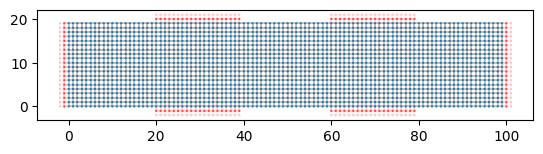

Bandgap = 0.0019


/Users/lehuuthong/miniconda3/envs/kwant-env/lib/python3.10/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/Users/lehuuthong/miniconda3/envs/kwant-env/lib/python3.10/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/Users/lehuuthong/miniconda3/envs/kwant-env/lib/python3.10/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/Users/lehuuthong/miniconda3/envs/kwant-env/lib/python3.10/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver wi

Plotting the relative error of transmission derivatives


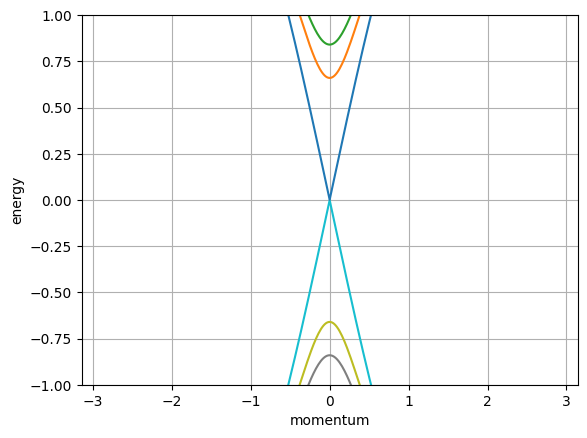

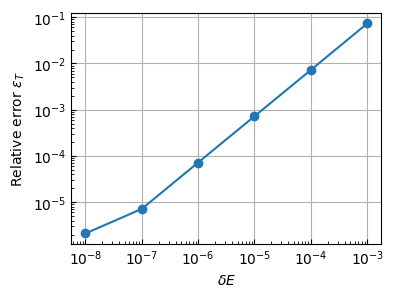

In [14]:
import Analysis
import Hamiltonians
import HallTransport

para_QAH = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 0.6, 'Mt': 2, 'Mb': 1, 'Es': 0, 'V0': 0}
M_min = min(abs(para_QAH['Mt']),abs(para_QAH['Mb']))
mu = 3
shift = 0
W = 20
L = 100
lead_pos = [[0, W], [1*L//5-shift, 2*L//5-shift], [3*L//5, 4*L//5], [0, W], [3*L//5, 4*L//5], [1*L//5-shift, 2*L//5-shift]]
Hamiltonian = Analysis.SystemCreator(para_QAH, Hamiltonians.Two_surface_model , (W, L), lead_pos=lead_pos)

E_check = 2
dE_derivative = 1e-6
System_2nd = HallTransport.HallResistance_2nd(Hamiltonian, energy=E_check, dE=dE_derivative)
System_2nd.evaluate_smatrix()
System_2nd.evaluate_wavefunctions()
System_2nd.evaluate_transmission_derivatives()
System_2nd.evaluate_HallResistance_2nd()
# System_2nd.test_chara_potential()
# plt.show()
fig, ax = System_2nd.test_transmission_derivatives_error()
#ticks inward
ax.tick_params(axis='both', which='both', direction='in')
fig.savefig("Figures/FigS7.pdf", dpi=300, bbox_inches='tight')

# System_2nd.test_conductance_2nd()
# System_2nd.test_idrop_2nd()

## Fig S10

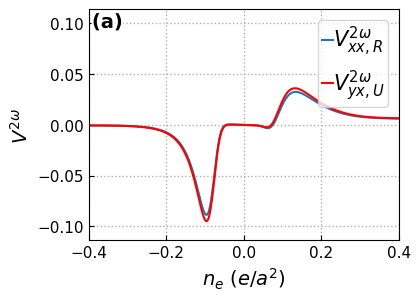

In [16]:
fig = plt.figure(figsize=(4, 3))
gs = gridspec.GridSpec(1, 1, wspace=0.3, hspace=0)

data = np.loadtxt("Data/EF_DOS_conversion.txt", comments="#")
Elist1 = data[:, 0]
Carrier_QAH = data[:, 1]
Carrier_Axion = data[:, 2]
xmax = 0.4
ax = fig.add_subplot(gs[0])
HallData_2nd = load_object_state_v2(HallTransport.HallResistanceData_2nd, "Data/Data_QAH_Assymetric.pkl")
f = interp1d(Elist1, Carrier_QAH, kind='linear', bounds_error=False, fill_value='extrapolate')
Carrier_interp = f(HallData_2nd.Elist)
PlotHallConductance_2nd_v1_1(Carrier_interp, HallData_2nd.Hall_resistance_2nd_avg, ax, legend=True, \
                               xmax=xmax, xlabel=r'$n_e\ (e/a^2)$')
ax.text(0.01, 0.92, r"(a)",
        transform=ax.transAxes, ha='left', 
        fontsize=14, fontweight='bold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel(r'$V^{2\omega}$', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in')
fig.savefig("Figures/FigS10.pdf", dpi=300, bbox_inches='tight')

## Fig S11

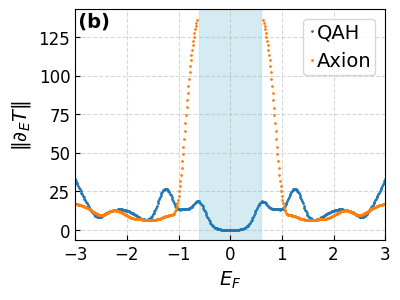

In [17]:
fig = plt.figure(figsize=(4, 3))
gs = gridspec.GridSpec(1, 1, wspace=0.3, hspace=0)

data = np.loadtxt("Data/EF_DOS_conversion.txt", comments="#")
Elist1 = data[:, 0]
Carrier_QAH = data[:, 1]
Carrier_Axion = data[:, 2]
xmax = 0.4

ax = fig.add_subplot(gs[0])
HallData_2nd = load_object_state_v2(HallTransport.HallResistanceData_2nd, "Data/Data_QAH_1.pkl")
f = interp1d(Elist1, Carrier_QAH , kind='linear', bounds_error=False, fill_value='extrapolate')
Carrier_interp = f(HallData_2nd.Elist)
ax.plot(HallData_2nd.Elist, HallData_2nd.transmission_dE_avg_norm, label='QAH', lw=0, marker='o', ms=1)
HallData_2nd = load_object_state_v2(HallTransport.HallResistanceData_2nd, "Data/Data_Axion_1.pkl")
f = interp1d(Elist1, Carrier_Axion, kind='linear', bounds_error=False, fill_value='extrapolate')
Carrier_interp = f(HallData_2nd.Elist)
ax.plot(HallData_2nd.Elist, HallData_2nd.transmission_dE_avg_norm, label='Axion', lw=0, marker='o', ms=1)
# ax.set_xlim(-1.5, 1.5)
ax.set_xlim(-3, 3)
ax.legend(loc='upper right', fontsize=14, frameon=True,
                borderpad=0.2, 
                handlelength=0.5, handletextpad=0.0,
                bbox_to_anchor=(1., 1.))     
ax.grid(True, linestyle='--', alpha=0.5) 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.01, 0.92, r"(b)", 
        transform=ax.transAxes, ha='left', 
        fontsize=14, fontweight='bold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.axvspan(-0.6,0.6, color='lightblue', alpha=0.5, label=None)
ax.set_ylabel(r'$\Vert \partial_E T\Vert$', fontsize=14)
ax.set_xlabel(r'$E_F$', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in')

fig.savefig("Figures/FigS11.pdf", dpi=300, bbox_inches='tight')

## Fig S8

In [18]:
Nk = 100

In [20]:
def DensityTopBottom(Wfc, Nz, Ny, Nx, norb, Projector_top, Projector_bottom):
    # Normalization wrt unit occupation in each surface
    Wfc = Wfc/np.linalg.norm(Wfc)

    Wfc_top = np.einsum('ab,cdeb->cdea',Projector_top, Wfc.reshape(Nz,Ny,Nx,norb)).reshape(Nz*Ny*Nx*norb)
    Density_top = Wfc_to_Density_1Dy(Wfc_top, Nz, Ny, Nx, norb)

    Wfc_bottom = np.einsum('ab,cdeb->cdea',Projector_bottom, Wfc.reshape(Nz,Ny,Nx,norb)).reshape(Nz*Ny*Nx*norb)
    Density_bottom = Wfc_to_Density_1Dy(Wfc_bottom, Nz, Ny, Nx, norb)
    
    return Density_top, Density_bottom

In [22]:
def BandData(kxlist, Hoppings, Projector_TopSlab, Nbands, Ny, Nz):
    Elist = np.zeros((len(kxlist), Nbands))
    StateList = np.zeros((len(kxlist), Nbands, Nbands), dtype=complex)
    for i, kx in enumerate(kxlist):
        Elist[i], StateList[i] = Bandstructure_kx(kx, Ny, Nz, Hoppings, None, None, Magnetization=False)
        
    top_weights = np.zeros((Nk, Nbands))
    for ib in range(Nbands):
        for ik in range(Nk):
            psi = StateList[ik, ib]/np.linalg.norm(StateList[ik, ib])  # Normalize the state
            # <psi|P|psi>
            top_weights[ik, ib] = np.real(np.dot(psi.conj(), Projector_TopSlab @ psi))
    top_weights
    return Elist, top_weights, StateList

In [23]:
ParaTwoSurface_QAH = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': 1.2, 'Mb': 0.2, 'Es': 0, 'V0': 0}
ParaTwoSurface_Axion = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': 1.2, 'Mb': -0.2, 'Es': 0, 'V0': 0}
ParaTwoSurface_Axion_1 = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': -1.2, 'Mb': +0.2, 'Es': 0, 'V0': 0}
ParaTwoSurface_QAH_1 = {'vf':2, 'm0': 0.1, 'B': -1, 'g': 1, 'Mt': -1.2, 'Mb': -0.2, 'Es': 0, 'V0': 0}

Hoppings_QAH = TwoSurfaceModel_originalbasis(*ParaTwoSurface_QAH.values())
Hoppings_Axion = TwoSurfaceModel_originalbasis(*ParaTwoSurface_Axion.values())
Hoppings_Axion_1 = TwoSurfaceModel_originalbasis(*ParaTwoSurface_Axion_1.values())
Hoppings_QAH_1 = TwoSurfaceModel_originalbasis(*ParaTwoSurface_QAH_1.values())

In [24]:
Nx, Ny, Nz =  1, 20, 1
onsite = Projector_top
tx= ty= tz = np.zeros_like(onsite)
Projector_TopSlab = create_hamiltonian_cube(onsite, tx, ty, tz, Nx, Ny, Nz).toarray()

onsite = Projector_bottom
tx= ty= tz = np.zeros_like(onsite)
Projector_BottomSlab = create_hamiltonian_cube(onsite, tx, ty, tz, Nx, Ny, Nz).toarray()

In [25]:
norb = Hoppings_QAH[0].shape[0]
Nvec = Nx * Ny * Nz * norb
Nbands = Nvec
Nk = 201
# kxlist = np.linspace(-np.pi, np.pi, Nk)
kxlist = 1*np.linspace(-1, 1, Nk)

Elist_QAH, top_weights_QAH, StateList_QAH = BandData(kxlist, Hoppings_QAH, Projector_TopSlab, Nbands, Ny, Nz)
Elist_Axion, top_weights_Axion, StateList_Axion = BandData(kxlist, Hoppings_Axion, Projector_TopSlab, Nbands, Ny, Nz)
Elist_Axion_1, top_weights_Axion_1, StateList_Axion_1 = BandData(kxlist, Hoppings_Axion_1, Projector_TopSlab, Nbands, Ny, Nz)
Elist_QAH_1, top_weights_QAH_1, StateList_QAH_1 = BandData(kxlist, Hoppings_QAH_1, Projector_TopSlab, Nbands, Ny, Nz)

In [26]:
kpicks = 3*np.array([0.1, -0.1])

kpick = kpicks[0]  # Pick the first k-point from kpicks
kpick_index_positive = np.abs(kxlist - kpick).argmin()
kpick = kxlist[kpick_index_positive]
Wfc_QAH_positive = StateList_QAH[kpick_index_positive, Nbands//2]
Wfc_Axion_positive = StateList_Axion[kpick_index_positive, Nbands//2]
Wfc_Axion_1_positive = StateList_Axion_1[kpick_index_positive, Nbands//2]
Wfc_QAH_1_positive = StateList_QAH_1[kpick_index_positive, Nbands//2]

Density_top_QAH_positive, Density_bottom_QAH_positive = DensityTopBottom(Wfc_QAH_positive, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)
Density_top_Axion_positive, Density_bottom_Axion_positive = DensityTopBottom(Wfc_Axion_positive, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)
Density_top_Axion_1_positive, Density_bottom_Axion_1_positive = DensityTopBottom(Wfc_Axion_1_positive, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)
Density_top_QAH_1_positive, Density_bottom_QAH_1_positive = DensityTopBottom(Wfc_QAH_1_positive, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)

kpick = kpicks[1]
kpick_index_negative = np.abs(kxlist - kpick).argmin()
Wfc_QAH_negative = StateList_QAH[kpick_index_negative, Nbands//2]
Wfc_Axion_negative = StateList_Axion[kpick_index_negative, Nbands//2]
Wfc_Axion_1_negative = StateList_Axion_1[kpick_index_negative, Nbands//2]
Wfc_QAH_1_negative = StateList_QAH_1[kpick_index_negative, Nbands//2]
Density_top_QAH_negative, Density_bottom_QAH_negative = DensityTopBottom(Wfc_QAH_negative, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)
Density_top_Axion_negative, Density_bottom_Axion_negative = DensityTopBottom(Wfc_Axion_negative, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)
Density_top_Axion_1_negative, Density_bottom_Axion_1_negative = DensityTopBottom(Wfc_Axion_1_negative, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)
Density_top_QAH_1_negative, Density_bottom_QAH_1_negative = DensityTopBottom(Wfc_QAH_1_negative, Nz, Ny, Nx, norb, Projector_top, Projector_bottom)


In [27]:
def Plot_weighted_band(ax, kxlist, Elist_QAH, top_weights_QAH, kpick_index_positive, kpick_index_negative, colors, cmap, colobar=False):
    for ib in range(0,Nbands):
        scatterplot = ax.scatter(
            kxlist, Elist_QAH[:, ib],
            c=top_weights_QAH[:, ib],
            alpha=1,
            cmap=cmap,
            s=2,
            marker='o',
            norm=None,
            edgecolors='none',
            vmin=0, vmax=1
        )
    ax.set_xlabel(r'$k_x$',fontsize=12, labelpad=-12)
    ax.set_ylim(-3, 3)
    ax.set_xlim(np.min(kxlist), np.max(kxlist))
    ax.set_xticks([-1, 1])
    ax.plot(kxlist[kpick_index_positive], Elist_QAH[kpick_index_positive, Nbands//2], marker='*', color=colors[0], markersize=7, zorder=10)
    ax.plot(kxlist[kpick_index_negative], Elist_QAH[kpick_index_negative, Nbands//2], marker='*', color=colors[1], markersize=7, zorder=10)
    ax.tick_params(axis='both', which='both', direction='in')
    if colobar:
        cax = inset_axes(ax,
                        width="6%",  # width = 3% of parent_bbox width
                        height="100%",  # height : 100%
                        loc='lower left',
                        bbox_to_anchor=(1.05, 0., 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0,
                        )
        fig.colorbar(scatterplot, cax=cax, label='Top surface weight')

def Plot_hinge_wfcn(ax, y, Density_top_QAH_positive, Density_top_QAH_negative, Density_bottom_QAH_positive, Density_bottom_QAH_negative, colors, legend=False):
    ax.plot(y+1, Density_top_QAH_positive, c=colors[0],linestyle=':', marker='o', ms=0,label='top,+')
    ax.plot(y+1, Density_top_QAH_negative, c=colors[1],linestyle=':', marker='o', ms=0,label='top,-')
    ax.plot(y+1, Density_bottom_QAH_positive, c=colors[0],label='bottom,+')
    ax.plot(y+1, Density_bottom_QAH_negative , c=colors[1],label='bottom,-')
    ax.set_xlabel(r'$y$',fontsize=12,labelpad=-10)
    ax.set_xticks([1,y[-1]+1])
    ax.set_xlim(1,y[-1]+1)
    ax.set_ylim(0)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_yticks([0,0.1,0.2])
    ax.tick_params(axis='both', which='both', direction='in')
    if legend: 
        ax.legend(loc='upper center', fontsize=10, frameon=True,
                borderpad=0.1, 
                handlelength=1, handletextpad=0.0, 
                bbox_to_anchor=(0.5, 0.9))

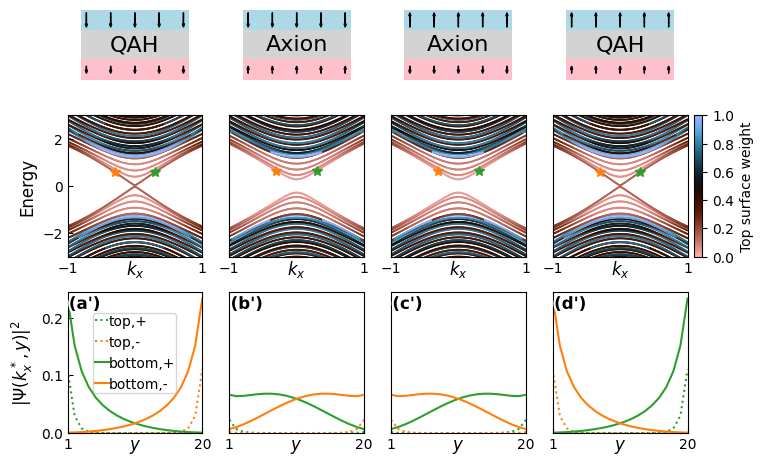

In [29]:
colors = ['tab:green', 'tab:orange']
cmap = 'berlin_r'
alpha = 0.5
y = np.arange(Ny)
markerscale = 2e3
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig=plt.figure(figsize=(8,5.5))
outer_gs = gridspec.GridSpec(3, 4, hspace=0.3,wspace=0.2, height_ratios=[0.5,1,1])  # spacing between pairs

ax = fig.add_subplot(outer_gs[0, 0])
Plot_TI_Structure(ax, Mtop=-1, MBottom=-0.5, text='QAH')

ax = fig.add_subplot(outer_gs[0, 1])
Plot_TI_Structure(ax, Mtop=-1, MBottom=0.5, text='Axion')

ax = fig.add_subplot(outer_gs[0, 2])
Plot_TI_Structure(ax, Mtop=1, MBottom=-0.5, text='Axion')

ax = fig.add_subplot(outer_gs[0, 3])
Plot_TI_Structure(ax, Mtop=1, MBottom=0.5, text='QAH')

ax = fig.add_subplot(outer_gs[1, 0])
Plot_weighted_band(ax, kxlist, Elist_QAH_1, top_weights_QAH_1, kpick_index_positive, kpick_index_negative, colors, cmap)
ax.text(0.01, 0.9, None, transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel('Energy',fontsize=12)

ax = fig.add_subplot(outer_gs[1, 1])
Plot_weighted_band(ax, kxlist, Elist_Axion_1, top_weights_Axion_1, kpick_index_positive, kpick_index_negative, colors, cmap)
ax.text(0.01, 0.9, None, transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_yticks([])

ax = fig.add_subplot(outer_gs[1, 2])
Plot_weighted_band(ax, kxlist, Elist_Axion, top_weights_Axion, kpick_index_positive, kpick_index_negative, colors, cmap)
ax.text(0.01, 0.9, None, transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_yticks([])

ax = fig.add_subplot(outer_gs[1, 3])
Plot_weighted_band(ax, kxlist, Elist_QAH, top_weights_QAH, kpick_index_positive, kpick_index_negative, colors, cmap, colobar=True)
ax.text(0.01, 0.9, None, transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_yticks([])

ax = fig.add_subplot(outer_gs[2, 0])
Plot_hinge_wfcn(ax, y, Density_top_QAH_1_positive, Density_top_QAH_1_negative, Density_bottom_QAH_1_positive, Density_bottom_QAH_1_negative, colors, legend=True)
ax.text(0.01, 0.88, r"(a')", transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylabel(r'$|\Psi(k_x^*,y)|^2$', fontsize=12)
ymax = ax.get_ylim()[1]

ax = fig.add_subplot(outer_gs[2, 1])
Plot_hinge_wfcn(ax, y, Density_top_Axion_1_positive, Density_top_Axion_1_negative, Density_bottom_Axion_1_positive, Density_bottom_Axion_1_negative, colors)
ax.text(0.01, 0.88, r"(b')", transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylim(0, ymax)
ax.set_yticks([])

ax = fig.add_subplot(outer_gs[2, 2])
Plot_hinge_wfcn(ax, y, Density_top_Axion_positive, Density_top_Axion_negative, Density_bottom_Axion_positive, Density_bottom_Axion_negative, colors)
ax.text(0.01, 0.88, r"(c')", transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylim(0, ymax)
ax.set_yticks([])

ax = fig.add_subplot(outer_gs[2, 3])
Plot_hinge_wfcn(ax, y, Density_top_QAH_positive, Density_top_QAH_negative, Density_bottom_QAH_positive, Density_bottom_QAH_negative, colors)
ax.text(0.01, 0.88, r"(d')", transform=ax.transAxes, ha='left', fontsize=12, fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set_ylim(0, ymax)
ax.set_yticks([])

fig.savefig('Figures/FigS8.png', dpi=1200, bbox_inches='tight')